In [1]:
!pip install --upgrade xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree._classes import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.1
    Uninstalling xgboost-2.1.1:
      Successfully uninstalled xgboost-2.1.1

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
file_path = '/Users/liziqi/NEU/DS5010/car_prices.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


## Data preprocessing

In [5]:
# drop rows with missing values & duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

### Column Reformation

In [6]:
df.rename(columns={'make': 'brand', 'body': 'body_type', 'odometer': 'mileage'}, inplace=True)

In [7]:
# dorp 'vin' column as it is not useful for our analysis
df.drop(columns=['vin'], inplace=True)

In [8]:
# calculate the sales year
df['sale_year'] = df['saledate'].str[11:15]
df['sale_year'] = pd.to_numeric(df['sale_year'], errors='coerce').astype('Int64')

In [9]:
df.head()

,year,brand,model,trim,body_type,transmission,state,condition,mileage,color,interior,seller,mmr,sellingprice,saledate,sale_year
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),2014


In [10]:
df.shape

(472325, 16)

### Handling Extrme Values

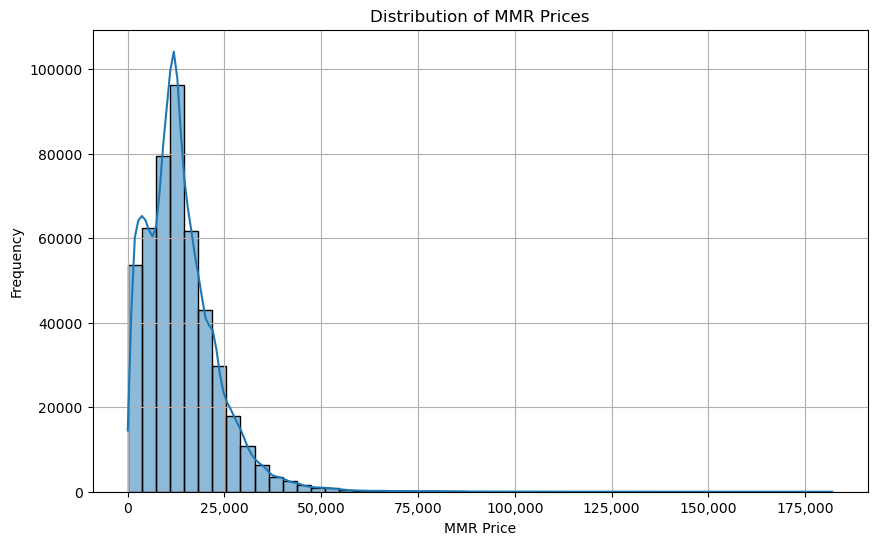

In [11]:
mmr_column = 'mmr'

plt.figure(figsize=(10, 6))
sns.histplot(df[mmr_column].dropna(), bins=50, kde=True)
plt.xlabel("MMR Price")
plt.ylabel("Frequency")
plt.title("Distribution of MMR Prices")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

    why choose this threshold?

In [12]:
mmr_column = 'mmr'

low_threshold = df[mmr_column].quantile(0.02)
high_threshold = df[mmr_column].quantile(0.98)

print(f"MMR lowwer {low_threshold:,.0f}")
print(f"MMR higher {high_threshold:,.0f}")

MMR lowwer 1,125
MMR higher 38,100


In [13]:
df['sale_year'].value_counts()

sale_year
2015    435536
2014     36789
Name: count, dtype: Int64

Since all sales are between 2014 & 2015, no need to adjust for inflation, can compare mmr & selling price at the same dollar value.

    why this threshold?

In [14]:
df = df[(df['mmr'] > 500) & (df['mmr'] < 45000)] 

df.shape

(466319, 16)

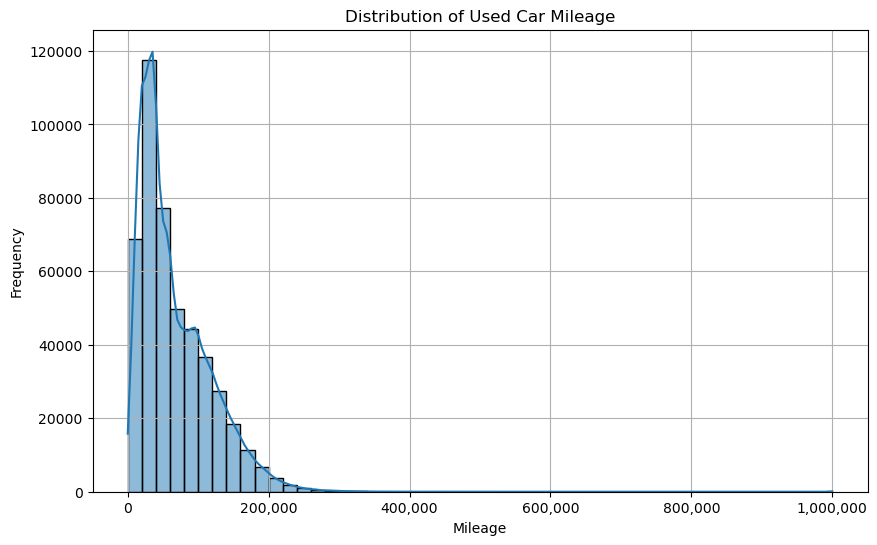

In [15]:
mileage_column = 'mileage'

plt.figure(figsize=(10, 6))
sns.histplot(df[mileage_column].dropna(), bins=50, kde=True)
plt.xlabel("Mileage")
plt.ylabel("Frequency")
plt.title("Distribution of Used Car Mileage")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

    again why this threshold

In [16]:
mileage_column = 'mileage'

low_threshold = df[mileage_column].quantile(0.02)
high_threshold = df[mileage_column].quantile(0.98)

print(f"mileage lowwer {low_threshold:,.0f}")
print(f"mileage higher {high_threshold:,.0f}")

mileage lowwer 6,147
mileage higher 194,577


In [17]:
df.shape

(466319, 16)

In [18]:
# new_df = df[(df['mileage'] > 5000) & (df['mileage'] < 200000)] 

# new_df.shape

In [19]:
# test_df = df[df['mileage'] > 200000] 
# test_df['mileage'].describe()

In [20]:
# test_df = df[df['mileage'] < 5000] 
# test_df['mileage'].describe()

    For subset having mileage less than 5000, its 25th quartile is still almost 1000, would it be better to decrease the threshold for lower bound?

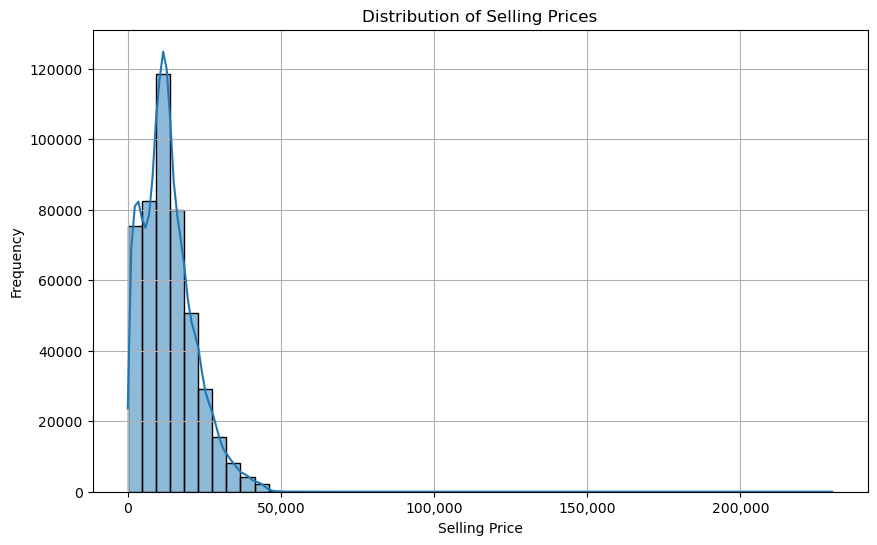

In [21]:
sellingprice_column = 'sellingprice'

plt.figure(figsize=(10, 6))
sns.histplot(df[sellingprice_column].dropna(), bins=50, kde=True)
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.title("Distribution of Selling Prices")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [22]:
price = 'sellingprice'

low_threshold = df[price].quantile(0.02)
high_threshold = df[price].quantile(0.98)

print(f"price lowwer {low_threshold:,.0f}")
print(f"price higher {high_threshold:,.0f}")

price lowwer 900
price higher 35,000


In [23]:
df = df[(df['sellingprice'] > 1000) & (df['sellingprice'] < 45000)]

df.shape

(454009, 16)

For 'year' column, since manufacturing year cannot exceed sales year, drop any records that does not satisfy this condition.

In [24]:
df = df[df['year'] <= df['sale_year']]

df.shape

(453868, 16)

add a new column 'car_age' that calculate car's age based on sales_year - manufacuring_year

In [25]:
df['car_age'] = df['sale_year'] - df['year']

    need to output a csv file here as the outcome of data preprocessing module

In [26]:
# output df_cleaned to a csv file named 'car_prices_cleaned.csv'
# df_cleaned.to_csv('car_prices_cleaned.csv', index=False)

## MMR Factor Analysis

The Manheim Market Report (MMR) is the premier indicator a vehicle's prices.
  
    **Baseline Model**: Assume MMR properly reflects the current market value of each vahicle, we need to analyze how various factors affect its pricing, giving different makes and models, combined with mileage adjustment, condition adjustment, market class, etc,.


    need to read the preprocessed file after splitting notebook for different modules

In [27]:
# df_cleaned = pd.read_csv('car_prices_cleaned.csv')

In [28]:
df_mmr = df.copy()

In [29]:
df_mmr.head()

,year,brand,model,trim,body_type,transmission,state,condition,mileage,color,interior,seller,mmr,sellingprice,saledate,sale_year,car_age
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015,1
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015,0
7,2014,Chevrolet,Cruze,1LT,Sedan,automatic,ca,2.0,28617.0,black,black,enterprise vehicle exchange / tra / rental / t...,11900.0,9800.0,Tue Dec 16 2014 13:00:00 GMT-0800 (PST),2014,0
8,2014,Audi,A4,2.0T Premium Plus quattro,Sedan,automatic,ca,42.0,9557.0,white,black,audi mission viejo,32100.0,32250.0,Thu Dec 18 2014 12:00:00 GMT-0800 (PST),2014,0
9,2014,Chevrolet,Camaro,LT,Convertible,automatic,ca,3.0,4809.0,red,black,d/m auto sales inc,26300.0,17500.0,Tue Jan 20 2015 04:00:00 GMT-0800 (PST),2015,1


### feature engineering

We need to explore what features relevant in impacting the calculation of depreciation rate per mileage.

In [30]:
# selecting relevant features based on empirical knowledge
relevant_features = ['brand','model', 'body_type', 'car_age', 'condition', 'transmission', 'mileage', 'mmr']
df_mmr = df_mmr[relevant_features]
df_mmr.head()

,brand,model,body_type,car_age,condition,transmission,mileage,mmr
2,BMW,3 Series,Sedan,1,45.0,automatic,1331.0,31900.0
3,Volvo,S60,Sedan,0,41.0,automatic,14282.0,27500.0
7,Chevrolet,Cruze,Sedan,0,2.0,automatic,28617.0,11900.0
8,Audi,A4,Sedan,0,42.0,automatic,9557.0,32100.0
9,Chevrolet,Camaro,Convertible,1,3.0,automatic,4809.0,26300.0


In [31]:
df_mmr['brand'].value_counts().shape

(47,)

In [32]:
df_mmr['model'].value_counts().shape

(706,)

In [33]:
df_mmr['body_type'].value_counts().shape

(82,)

In [34]:
df_mmr['transmission'].value_counts().shape

(2,)

Since different brands have vary different names for model, so the column 'model' itself does not apply to our factor analysis. **Drop it** <br>
Both 'brand' and 'body_type' are high dimensional categorical variables --> use label encoding to convert them to numeric values

In [35]:
df_mmr.drop('model', axis=1, inplace=True)
df_mmr.head()

,brand,body_type,car_age,condition,transmission,mileage,mmr
2,BMW,Sedan,1,45.0,automatic,1331.0,31900.0
3,Volvo,Sedan,0,41.0,automatic,14282.0,27500.0
7,Chevrolet,Sedan,0,2.0,automatic,28617.0,11900.0
8,Audi,Sedan,0,42.0,automatic,9557.0,32100.0
9,Chevrolet,Convertible,1,3.0,automatic,4809.0,26300.0


In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
# label encoding for categorical features
le = LabelEncoder()
df_mmr['brand'] = le.fit_transform(df_mmr['brand'])
df_mmr['body_type'] = le.fit_transform(df_mmr['body_type'])
df_mmr['transmission'] = le.fit_transform(df_mmr['transmission'])
df_mmr.head()

,brand,body_type,car_age,condition,transmission,mileage,mmr
2,3,34,1,45.0,0,1331.0,31900.0
3,45,34,0,41.0,0,14282.0,27500.0
7,7,34,0,2.0,0,28617.0,11900.0
8,2,34,0,42.0,0,9557.0,32100.0
9,7,8,1,3.0,0,4809.0,26300.0


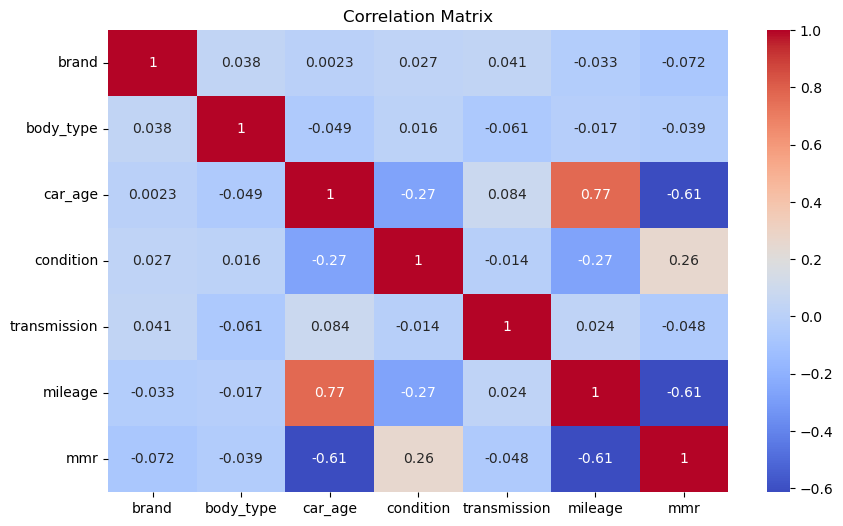

In [38]:
# conduct correlation analysis to remove multicollinearity
corr_matrix = df_mmr.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In this correlation matrix, **'car age' and 'mileage'** show a high correlation, so we need to drop one feature to prevent multicollinearity.
<br>
We decided to select 'mileage' for training  as it best indicate each vehicle's depreciation. 

In [39]:
df_mmr.drop('car_age', axis=1, inplace=True)
df_mmr.head()

,brand,body_type,condition,transmission,mileage,mmr
2,3,34,45.0,0,1331.0,31900.0
3,45,34,41.0,0,14282.0,27500.0
7,7,34,2.0,0,28617.0,11900.0
8,2,34,42.0,0,9557.0,32100.0
9,7,8,3.0,0,4809.0,26300.0


In [40]:
# standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_mmr[[ 'condition', 'brand', 'body_type', 'transmission', 'mileage', 'mmr']] = scaler.fit_transform(df_mmr[[ 'condition', 'brand', 'body_type', 'transmission', 'mileage', 'mmr']])
df_mmr.head()

,brand,body_type,condition,transmission,mileage,mmr
2,-1.262371,-0.188425,1.061583,-0.186013,-1.298652,2.235826
3,2.066911,-0.188425,0.752880,-0.186013,-1.032008,1.694450
7,-0.945296,-0.188425,-2.256971,-0.186013,-0.736870,-0.224974
8,-1.341640,-0.188425,0.830056,-0.186013,-1.129289,2.260434
9,-0.945296,-1.712004,-2.179795,-0.186013,-1.227044,1.546802


### Model training

I choose decision tree model as a baseline model given the presumption that the depreciation rate is primarily driven by mileage, and I want to explore how other relevant features can impact the depreciation rate

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X, y = df_mmr.drop(columns=['mmr']), df_mmr['mmr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# make sure training data & test data have the same number of features and acceptable number of samples
print(X_train.shape)
print(X_test.shape)

(363094, 5)
(90774, 5)


In [44]:
from sklearn.tree._classes import DecisionTreeRegressor

In [45]:
# train a decision tree model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [46]:
# make predictions
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

**success metrics**: use RMSE to measure the error of predictions on both training & test data

In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Model Training RMSE: {train_rmse:.2f}")
print(f"Model Test RMSE: {test_rmse:.2f}")

Model Training RMSE: 0.02
Model Test RMSE: 0.67


In [48]:
# print the coefficient of the decision tree model 
for feature, importance in zip(X.columns, dt.feature_importances_):
    print(f"{feature}: {importance:.2f}")

brand: 0.17
body_type: 0.19
condition: 0.06
transmission: 0.00
mileage: 0.58


Results not good, try more complex model.

#### Random forest

In [49]:
# use random forest regressor
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [50]:
# make predictions
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

In [51]:
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Model Training RMSE: {train_rmse:.2f}")
print(f"Model Test RMSE: {test_rmse:.2f}")

Model Training RMSE: 0.19
Model Test RMSE: 0.52


In [52]:
# print the coefficient of the decision tree model 
for feature, importance in zip(X.columns, rfr.feature_importances_):
    print(f"{feature}: {importance:.2f}")

brand: 0.17
body_type: 0.19
condition: 0.07
transmission: 0.00
mileage: 0.57


#### XGBoost

In [53]:
# use xgboost to train a regression model
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
# make predictions
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

In [55]:
# calculate r squared score of the model
train_r2 = xgb.score(X_train, y_train)
test_r2 = xgb.score(X_test, y_test)
print(f"Model Training R^2: {train_r2:.2f}")
print(f"Model Test R^2: {test_r2:.2f}")

Model Training R^2: 0.78
Model Test R^2: 0.77


In [56]:
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Model Training RMSE: {train_rmse:.2f}")
print(f"Model Test RMSE: {test_rmse:.2f}")

Model Training RMSE: 0.47
Model Test RMSE: 0.48


In [57]:
# print the coefficient of the xgboost model
for feature, importance in zip(X.columns, xgb.feature_importances_):
    print(f"{feature}: {importance:.2f}")

brand: 0.19
body_type: 0.22
condition: 0.05
transmission: 0.02
mileage: 0.52


After training with different non-linear tree models, xgboost outperforms other models by yielding a r^2 score of **0.77**  and the smallest RMSE of **0.48** without overfitting. This model shows that the top dominant feature affecting mmr is **'mileage'** with a feature importance of 0.52.

**However, we suspected different brands and models should have stronger impact on the MMR of each vehicle, but we simply label encoded the two columns in our baseline model.**

    In this case, we need to take a deeper dive into the specific brands and models in our dataset, and segment different types of cars (ex.SUV, economics, etc.,) and optimize our model with empirical knowledge.

In [69]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0]
}

xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE (CV):", (-grid_search.best_score_)**0.5)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best RMSE (CV): 0.4728333405972497


In [76]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

best_params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'n_estimators': 200,
    'subsample': 1.0,
    'random_state': 42
}

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

for feature, importance in zip(X.columns, xgb.feature_importances_):
    print(f"{feature}: {importance:.2f}")


Test RMSE: 0.4730
Test R²: 0.7773
brand: 0.20
body_type: 0.23
condition: 0.04
transmission: 0.02
mileage: 0.51


#### XGBoost Model Tuning Summary

Initially, we trained an XGBoost regression model using default parameters to predict the market value (MMR) of vehicles. While the model performed reasonably well (Test RMSE ≈ 0.48, R² ≈ 0.77), we aimed to further improve its performance and robustness through hyperparameter tuning using `GridSearchCV`.

##### Tuning Objective

To optimize the model's ability to generalize on unseen data by adjusting key parameters that control its learning process and complexity.

##### Parameter Grid Used

We searched across the following parameter combinations:

- `learning_rate`: [0.01, 0.1, 0.3]
- `max_depth`: [3, 5, 7]
- `n_estimators`: [50, 100, 200]
- `subsample`: [0.7, 1.0]

This resulted in 54 combinations, and we performed 3-fold cross-validation on each (162 fits in total).

##### Best Parameters Found

```python
{
    'learning_rate': 0.1,
    'max_depth': 7,
    'n_estimators': 200,
    'subsample': 1.0
}


#  Value Retention Module

In [59]:
#Step 1: Data Loading and Cleaning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Step 1: Data Loading and Cleaning")
file_path ='/Users/liziqi/NEU/DS5010/car_prices.csv'
print(f"Loading data from {file_path}...")
df = pd.read_csv(file_path)

column_mapping = {
    'make': 'brand',
    'body': 'body_type',
    'odometer': 'mileage'
}
for old_col, new_col in column_mapping.items():
    if old_col in df.columns:
        df.rename(columns={old_col: new_col}, inplace=True)

# Remove rows with missing values in key columns
df = df.dropna(subset=['sellingprice', 'mmr', 'mileage', 'year'])

# Extract sale year from the date string and convert to integer
df['sale_year'] = df['saledate'].str[11:15].astype(int)
# Calculate vehicle age (years between sale and manufacturing)
df['car_age'] = df['sale_year'] - df['year']

# Filter out outliers that could skew our analysis
df = df[(df['sellingprice'] > 1000) & (df['sellingprice'] < 100000)]
df = df[(df['mileage'] > 5000) & (df['mileage'] < 200000)]
df = df[df['car_age'] >= 0]  # Remove invalid ages

print(f"Number of records after cleaning: {len(df)}")

# Calculate value retention ratio (selling price / market value)
df['value_retention_ratio'] = (df['sellingprice'] / df['mmr']).round(4)

# Display a sample of the cleaned data
df[['year', 'sale_year', 'car_age', 'sellingprice', 'mmr', 'value_retention_ratio']].head()

Step 1: Data Loading and Cleaning
Loading data from /Users/liziqi/NEU/DS5010/car_prices.csv...
Number of records after cleaning: 524098


,year,sale_year,car_age,sellingprice,mmr,value_retention_ratio
3,2015,2015,0,27750.0,27500.0,1.0091
6,2014,2014,0,65000.0,69000.0,0.9420
7,2014,2014,0,9800.0,11900.0,0.8235
8,2014,2014,0,32250.0,32100.0,1.0047
10,2014,2014,0,49750.0,47300.0,1.0518


In [60]:
#Step 2: Creating Cohorts and Time Periods

print("\nStep 2: Creating Cohorts and Time Periods")

# Group vehicles by manufacturing year to create cohorts
df['cohort'] = df['year']
print(f"Created {df['cohort'].nunique()} cohorts based on manufacturing year")

# Check the distribution of vehicles across cohorts
cohort_counts = df['cohort'].value_counts().sort_index()
print("\nNumber of vehicles in each cohort:")
print(cohort_counts.head(10))  # Show the first 10 cohorts

# Examine the vehicle age distribution
print(f"\nVehicle age range: {df['car_age'].min()} to {df['car_age'].max()} years")
print("\nVehicle age distribution:")
print(df['car_age'].value_counts().sort_index().head(10))  # Show first 10 ages


Step 2: Creating Cohorts and Time Periods
Created 34 cohorts based on manufacturing year

Number of vehicles in each cohort:
cohort
1982     2
1983     1
1984     5
1985     9
1986     6
1987     3
1988     4
1989     5
1990    11
1991    17
Name: count, dtype: int64

Vehicle age range: 0 to 33 years

Vehicle age distribution:
car_age
0    12229
1    78217
2    98025
3    99519
4    45964
5    25713
6    21507
7    30944
8    29343
9    24597
Name: count, dtype: int64


In [61]:
# Step 3: Cohort Analysis Creation

# Step 3: Build the cohort analysis
print("\nStep 3: Building Cohort Analysis")

# Group data by cohort and vehicle age, then calculate average retention ratio
cohort_data = df.groupby(['cohort', 'car_age'])['value_retention_ratio'].agg(['mean', 'count']).reset_index()
print("Sample of cohort data:")
print(cohort_data.head())

# Create a pivot table for easier visualization and analysis
cohort_pivot = cohort_data.pivot_table(
    index='cohort',
    columns='car_age',
    values='mean'
)

print("\nValue retention ratio pivot table:")
print(cohort_pivot.head())

# Create a sample size pivot table to validate our insights
count_pivot = cohort_data.pivot_table(
    index='cohort',
    columns='car_age',
    values='count'
)

print("\nSample sizes for each cohort-age combination:")
print(count_pivot.head())


Step 3: Building Cohort Analysis
Sample of cohort data:
   cohort  car_age      mean  count
0    1982       33  3.193950      2
1    1983       32  0.867800      1
2    1984       31  1.099120      5
3    1985       29  1.795500      2
4    1985       30  1.096786      7

Value retention ratio pivot table:
car_age  0   1   2   3   4   5   6   7   8   9   ...  24  25  26  27      28  \
cohort                                           ...                           
1982    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN     NaN   
1983    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN     NaN   
1984    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN     NaN   
1985    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN     NaN   
1986    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN  0.8615   

car_age       29        30       31      32       33  
cohort                                                
1982         NaN    


Step 4: Visualizing Retention Patterns


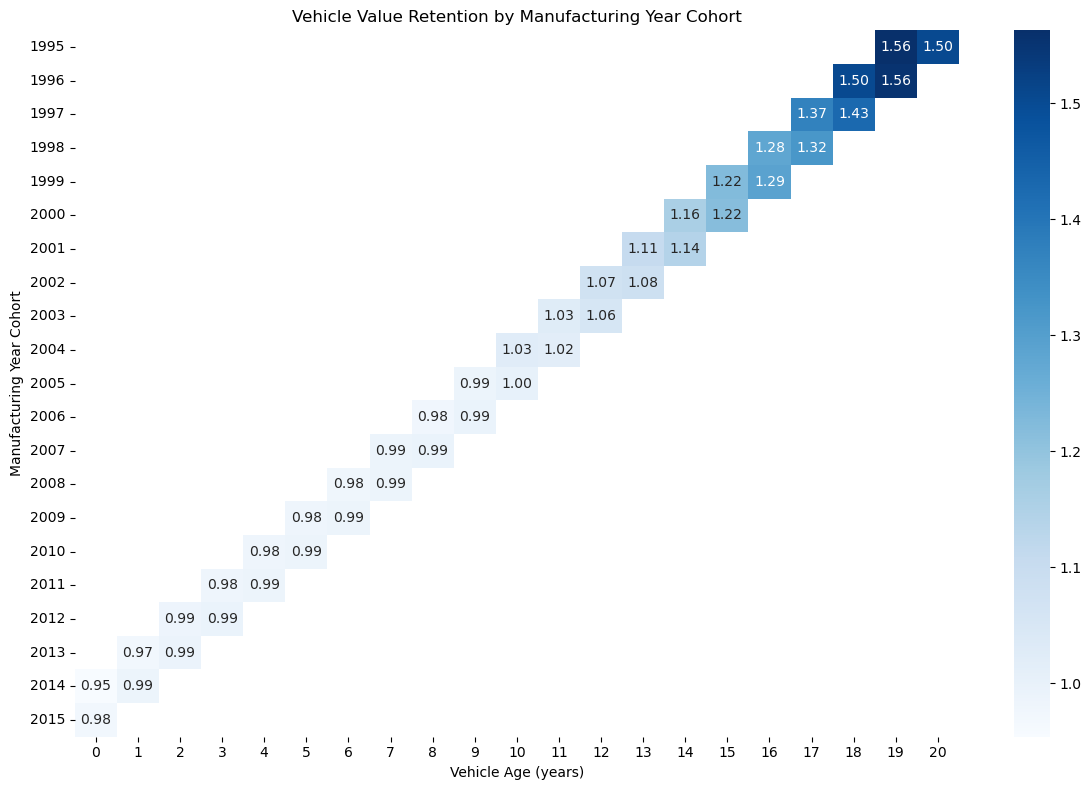

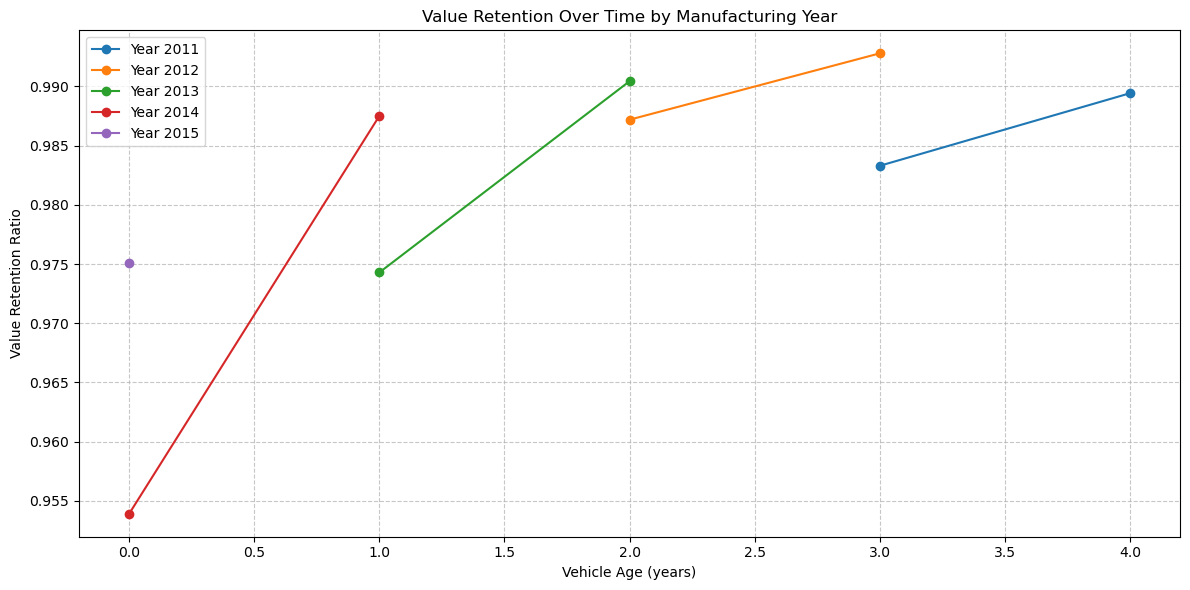

In [62]:
# Step 4: Visualization
# Step 4: Visualize the retention patterns
print("\nStep 4: Visualizing Retention Patterns")

# filter to include only cohorts and ages with sufficient data
# just setting a minimum threshold of 100 samples per cohort
valid_cohorts = count_pivot.index[count_pivot.sum(axis=1) >= 100]
# minimum of 100 samples per age bracket
valid_ages = count_pivot.columns[count_pivot.sum() >= 100]

# filter the pivot table
filtered_pivot = cohort_pivot.loc[valid_cohorts, valid_ages]

# create a heatmap to visualize retention patterns
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_pivot, annot=True, fmt='.2f', cmap='Blues')
plt.title('Vehicle Value Retention by Manufacturing Year Cohort')
plt.xlabel('Vehicle Age (years)')
plt.ylabel('Manufacturing Year Cohort')
plt.tight_layout()
plt.show()

# create a line chart to compare retention curves by year
plt.figure(figsize=(12, 6))
for year in sorted(filtered_pivot.index)[-5:]:  # Select the 5 most recent years
    if year in filtered_pivot.index:
        plt.plot(filtered_pivot.columns, filtered_pivot.loc[year], marker='o', label=f'Year {year}')

plt.title('Value Retention Over Time by Manufacturing Year')
plt.xlabel('Vehicle Age (years)')
plt.ylabel('Value Retention Ratio')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Step 5: Interpretation and Insights
Average value retention ratio by vehicle age:
Age 0 years: 0.96
Age 1 years: 0.98
Age 2 years: 0.99
Age 3 years: 0.99
Age 4 years: 0.99
Age 5 years: 0.99
Age 6 years: 0.98
Age 7 years: 0.99
Age 8 years: 0.98
Age 9 years: 0.99
Age 10 years: 1.01
Age 11 years: 1.02
Age 12 years: 1.06
Age 13 years: 1.10
Age 14 years: 1.15
Age 15 years: 1.22
Age 16 years: 1.29
Age 17 years: 1.35
Age 18 years: 1.47
Age 19 years: 1.56
Age 20 years: 1.50

Manufacturing years ranked by average value retention:
Year 1995: 1.53
Year 1996: 1.53
Year 1997: 1.40
Year 1998: 1.30
Year 1999: 1.26

Average value retention by brand:


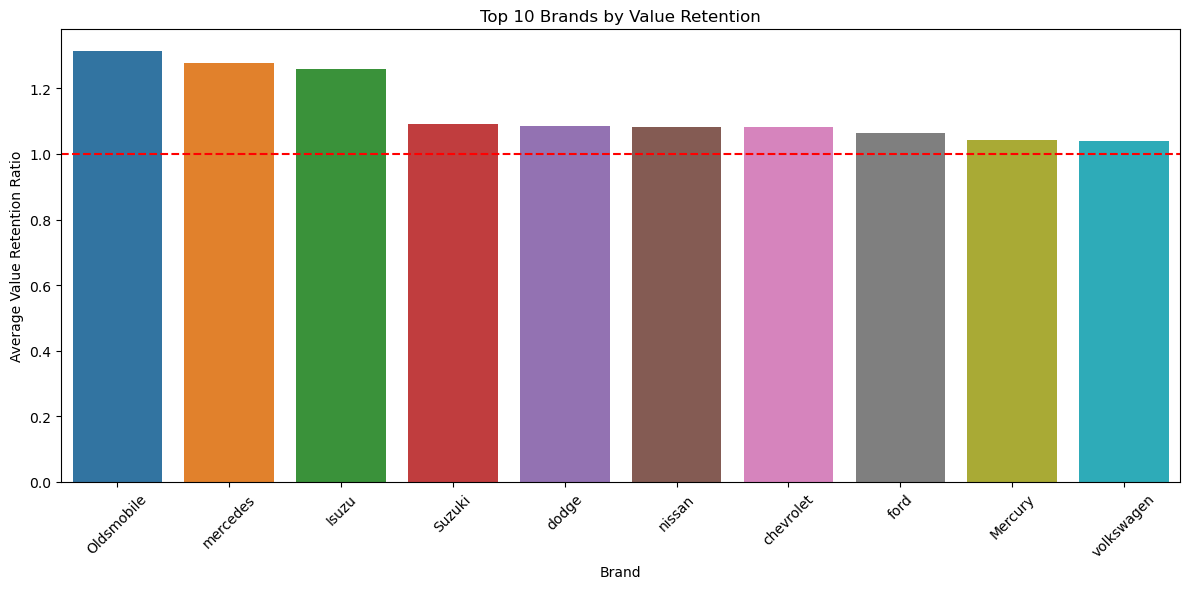

In [63]:
# Step 5: Interpretation & Interpret the results
print("\nStep 5: Interpretation and Insights")

# Calculate average retention ratios by vehicle age
avg_retention = filtered_pivot.mean(axis=0)
print("Average value retention ratio by vehicle age:")
for age, retention in avg_retention.items():
    print(f"Age {age} years: {retention:.2f}")

# Identify manufacturing years with the best value retention
best_years = filtered_pivot.mean(axis=1).sort_values(ascending=False)
print("\nManufacturing years ranked by average value retention:")
for year, retention in best_years.head(5).items():
    print(f"Year {year}: {retention:.2f}")

# Additional analysis: Value retention by brand
print("\nAverage value retention by brand:")
brand_retention = df.groupby('brand')['value_retention_ratio'].agg(['mean', 'count'])
brand_retention = brand_retention[brand_retention['count'] >= 20].sort_values('mean', ascending=False)

# Visualize the top brands by value retention
plt.figure(figsize=(12, 6))
sns.barplot(x=brand_retention.index[:10], y=brand_retention['mean'][:10])
plt.title('Top 10 Brands by Value Retention')
plt.xlabel('Brand')
plt.ylabel('Average Value Retention Ratio')
plt.xticks(rotation=45)
plt.axhline(y=1.0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

# Analyze value retention by market category if available
if 'market_category' in df.columns:
    category_retention = df.groupby('market_category')['value_retention_ratio'].agg(['mean', 'count'])
    category_retention = category_retention[category_retention['count'] >= 20].sort_values('mean', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=category_retention.index, y=category_retention['mean'])
    plt.title('Average Value Retention by Market Category')
    plt.xlabel('Market Category')
    plt.ylabel('Average Value Retention Ratio')
    plt.xticks(rotation=45)
    plt.axhline(y=1.0, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()


Step 6: Advanced Insights – Model-Level & Statistical Analysis


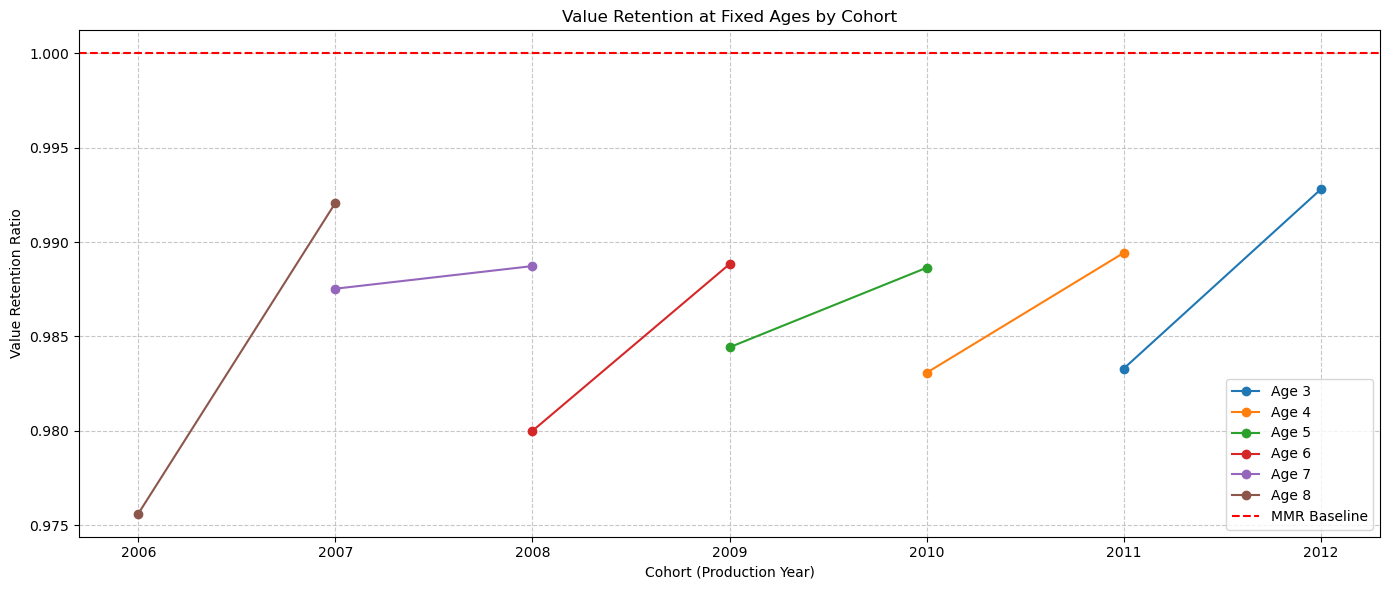


Top 10 Value-Retaining Models:
          brand          model  avg_retention  avg_meter_value  count
102    Cadillac       Eldorado       1.693010        44.872101     31
373       Isuzu          Rodeo       1.444662        71.151469     40
640      Saturn       S-Series       1.436836        79.115119     75
175    Chrysler           300M       1.392479        74.391599     48
589  Oldsmobile          Alero       1.383777        82.479143     39
455     Lincoln    Continental       1.356956        67.909467     32
170   Chevrolet        Venture       1.335386        90.837150     79
265        Ford       Windstar       1.312217        82.305181     78
555  Mitsubishi  Montero Sport       1.298990        90.463987     79
610     Pontiac        Sunfire       1.296611        67.024260     38

Regression Summary: Value Retention ~ Car Age + Cohort
                              OLS Regression Results                             
Dep. Variable:     value_retention_ratio   R-squared:       

In [77]:
# Step 6: Advanced Insights – Model-Level & Statistical Analysis
print("\nStep 6: Advanced Insights – Model-Level & Statistical Analysis")

# 1. Analyze value retention across cohorts at fixed vehicle ages
fixed_ages = [3, 4, 5, 6, 7, 8]
plt.figure(figsize=(14, 6))
for age in fixed_ages:
    age_df = df[df['car_age'] == age].groupby('cohort')['value_retention_ratio'].mean().reset_index()
    plt.plot(age_df['cohort'], age_df['value_retention_ratio'], marker='o', label=f'Age {age}')
plt.title('Value Retention at Fixed Ages by Cohort')
plt.xlabel('Cohort (Production Year)')
plt.ylabel('Value Retention Ratio')
plt.axhline(y=1.0, color='red', linestyle='--', label='MMR Baseline')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Analyze value retention and usage efficiency by brand and model
df['meter_value_ratio'] = df['mileage'] / df['sellingprice']

model_summary = df.groupby(['brand', 'model']).agg(
    avg_retention=('value_retention_ratio', 'mean'),
    avg_meter_value=('meter_value_ratio', 'mean'),
    count=('value_retention_ratio', 'count')
).reset_index()

# Filter for reliable combinations with sufficient sample size
filtered_models = model_summary[model_summary['count'] >= 30]

# Sort by average retention ratio to find top-performing models
top_models = filtered_models.sort_values(by='avg_retention', ascending=False)

print("\nTop 10 Value-Retaining Models:")
print(top_models.head(10))

# 3. Quantify the impact of vehicle age and manufacturing cohort using regression
import statsmodels.formula.api as smf

# Limit the dataset to vehicles 10 years old or younger
model_df = df[df['car_age'] <= 10]

# Fit an OLS regression model
model = smf.ols('value_retention_ratio ~ car_age + cohort', data=model_df).fit()

print("\nRegression Summary: Value Retention ~ Car Age + Cohort")
print(model.summary())



Step 7: Value Retention by Vehicle Type

Average value retention ratio by vehicle type:
              body_type      mean   count
30      Q60 Convertible  1.045577      35
8              Club Cab  1.040040     147
78             supercab  1.036602     831
75          regular cab  1.017794     726
9           Convertible  1.016895    8102
58         extended cab  1.016604     622
83                  van  1.014287     517
22        Genesis Coupe  1.012662     221
41                  Van  1.011838    3408
10                Coupe  1.011220   13080
64        genesis coupe  1.009841      59
2             CTS Coupe  1.009667     127
56         e-series van  1.008864     353
51          crewmax cab  1.008824     118
31            Q60 Coupe  1.008683      30
49                coupe  1.006606    2851
70              minivan  1.005960    3912
84                wagon  1.005052    2340
48          convertible  1.004986    1718
59        g convertible  1.004629      73
61              g sedan  1.00

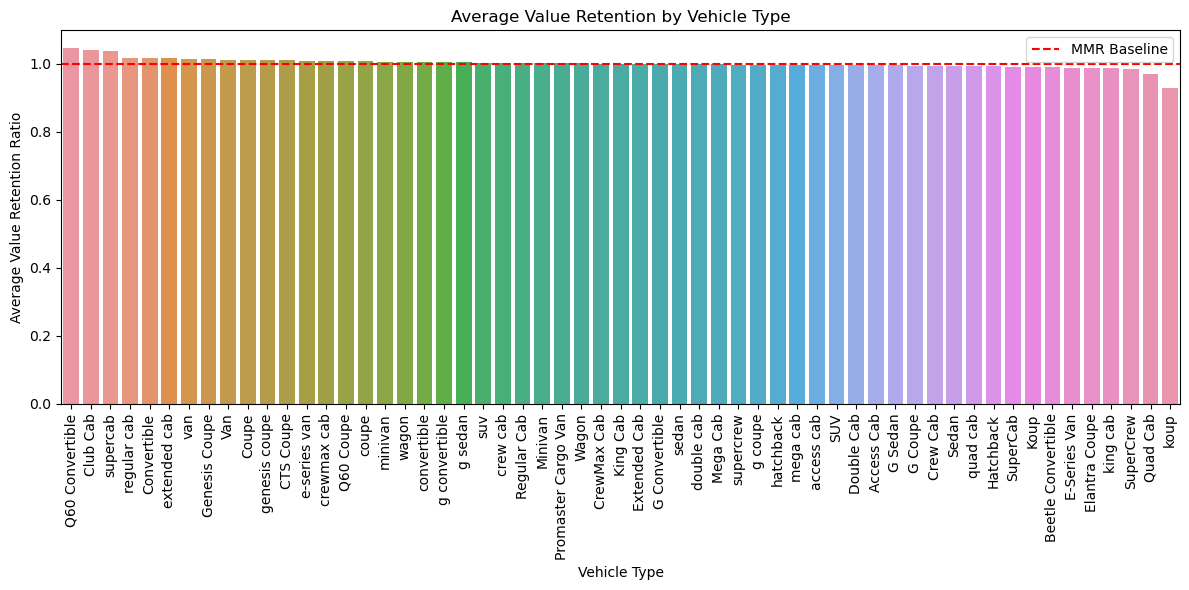


Value retention at age 5 by vehicle type:
       body_type      mean  count
22           Van  1.018759    121
41   regular cab  1.009894     48
1    Convertible  1.006573    230
44     supercrew  1.005935    176
25         coupe  1.001604    245
43      supercab  0.998654     80
4    CrewMax Cab  0.997102     53
18           SUV  0.995692   5873
3       Crew Cab  0.995030    795
26      crew cab  0.994723    197
2          Coupe  0.993715    958
45           suv  0.992636   1365
11     Hatchback  0.992164    955
40      quad cab  0.989237     43
31  extended cab  0.988196     48
15       Minivan  0.987050   1001
39       minivan  0.986306    204
20      SuperCab  0.985672    433
23         Wagon  0.985608    999
17   Regular Cab  0.984383    198
7   Extended Cab  0.983951    215
16      Quad Cab  0.983683    180
24   convertible  0.981729     52
19         Sedan  0.981651   7781
21     SuperCrew  0.981226    720
42         sedan  0.979726   1618
47         wagon  0.972878    202
35   

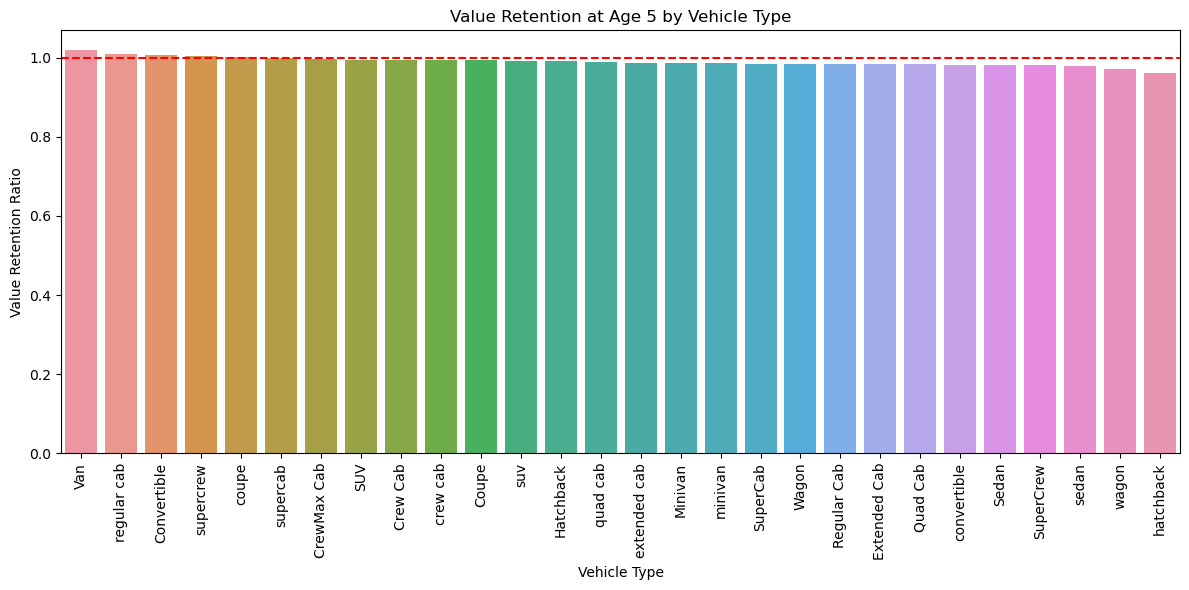

In [78]:
# Step 7: Value Retention by Vehicle Type
print("\nStep 7: Value Retention by Vehicle Type")

# 1. Average value retention by vehicle type
if 'body_type' in df.columns:
    body_retention = df.groupby('body_type')['value_retention_ratio'].agg(['mean', 'count']).reset_index()
    body_retention = body_retention[body_retention['count'] >= 30].sort_values('mean', ascending=False)

    print("\nAverage value retention ratio by vehicle type:")
    print(body_retention)

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(data=body_retention, x='body_type', y='mean')
    plt.axhline(y=1.0, color='red', linestyle='--', label='MMR Baseline')
    plt.title('Average Value Retention by Vehicle Type')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Average Value Retention Ratio')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Value retention at a fixed vehicle age (e.g., age 5) by type
    age_focus = 5
    age_df = df[df['car_age'] == age_focus]
    type_age_retention = age_df.groupby('body_type')['value_retention_ratio'].agg(['mean', 'count']).reset_index()
    type_age_retention = type_age_retention[type_age_retention['count'] >= 30].sort_values('mean', ascending=False)

    print(f"\nValue retention at age {age_focus} by vehicle type:")
    print(type_age_retention)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=type_age_retention, x='body_type', y='mean')
    plt.title(f'Value Retention at Age {age_focus} by Vehicle Type')
    plt.axhline(y=1.0, color='red', linestyle='--')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Value Retention Ratio')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'body_type' not found in dataset.")
